Connected to FF_DRL (Python 3.10.9)

In [1]:
import gym
from gym import wrappers

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt


# plotting a graph of multiples tuples as points
def plot_tuples(tuples_list, x_label, y_label, title):
    # Extract x and y values from the list of tuples
    x_values, y_values = zip(*tuples_list)
    # Create a line plot
    plt.plot(x_values, y_values, marker='o', linestyle='-')
    # Add labels and a title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # Show the plot
    plt.show()


def DRL_train_network(env, ff_net, num_episodes=500):
    # Hyperparameters
    learning_rate = 0.001
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    memory_capacity = 1000
    batch_size = 32


    # Initialize replay memory for good moves
    episode_memory = []
    # Initialize replay memory for good moves
    replay_memory_positive_list = []
    # Initialize replay memory for bad moves
    replay_memory_negative_list = []
    
    # Initialize epsilon for epsilon-greedy exploration
    epsilon = epsilon_start
    # Reward evolution 
    reward_evolution = [] 
    # Episode length evolution
    ep_length_evolution = []


    #% Training loop
    for episode in range(num_episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        total_reward = 0
        episode_length = 0

        # This loop plays an episode until the agent dies
        while not done and episode_length < 2000:
            episode_length += 1
            # Epsilon-greedy exploration
            if random.random() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                with torch.no_grad():
                    # create intput state-action with default action being 0
                    input_1  = torch.cat((state, torch.tensor([1])), dim=0)
                    action_1 = ff_net.predict(input_1).item()
                    input_0  = torch.cat((state, torch.tensor([0])), dim=0)
                    action_0 = ff_net.predict(input_0).item()
                    action = 1 if action_1 > action_0 else 0
            # Take the selected action (New API)
            next_state, reward, terminated, truncated, info = env.step(action)
            # New API, the done flag can be detected wether the episode failed or succed
            done = terminated or truncated
            # put in a torch tensor
            next_state = torch.tensor(next_state, dtype=torch.float32)
            # Store the transition in replay memory
            # replay_memory.append((state, action, reward, next_state, done))
            # Just store the state action pair
            # TODO : idea, put the next state into the input of the netwrok to have a kind of anticipation??
            # Normally can't be done due to the enviornment
            episode_memory.append(torch.cat((state, torch.tensor([action])), dim=0))
            total_reward += reward
            state = next_state


        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        # sort the replay memory such that the good runs stays in it (for better estimation of pos and neg data)
        replay_memory_positive_list.append(episode_memory[10:-10])
        replay_memory_positive_list = sorted(replay_memory_positive_list, key=len, reverse=True)
        replay_memory_positive = [item for sublist in replay_memory_positive_list for item in sublist]
        if len(replay_memory_positive_list) > 50:
            replay_memory_positive_list.pop()
    
        replay_memory_negative_list.append(episode_memory[-5:])
        replay_memory_negative_list = sorted(replay_memory_negative_list, key=len, reverse=True)
        replay_memory_negative = [item for sublist in replay_memory_negative_list for item in sublist]
        if len(replay_memory_negative_list) > 50:
            replay_memory_negative_list.pop()
            
        # Clear the replay memory of 1 run
        if len(replay_memory_positive) > memory_capacity:
            # Simple memory inside an array
            for _ in range(len(replay_memory_positive)-memory_capacity):
                # pop the last item of the list which should be the smallest run
                replay_memory_positive.pop()
            
        if len(replay_memory_negative) > memory_capacity:
            # Simple memory inside an array
            for _ in range(len(replay_memory_negative)-memory_capacity):
                # pop the last item of the list which should be the smallest run
                replay_memory_negative.pop()
                
        episode_memory.clear() # clear the memory of the past episode
        

        # Selecting k random sample in pos/neg memory data
        # x_pos has to be in a tensor
        neg_selection = random.choices(replay_memory_negative, k=128)
        # x_pos and x_neg must be tensor
        x_neg = torch.stack(neg_selection)
        if replay_memory_positive: # early stage when no pos data
            pos_selection = random.choices(replay_memory_positive, k=128)
            # x_pos and x_neg must be tensor
            x_pos = torch.stack(pos_selection)
        else:
            # Handle the case when replay_memory_positive is empty
            pos_selection = []        
        
        
        # Train the net if their is enough data
        if pos_selection and neg_selection:
            ff_net.train(x_pos,x_neg, num_epochs=100)
       
        
        # Log graph and plot outputs
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")
        print(f'length of repNeglist: {len(replay_memory_negative_list)} length of repNeg: {len(replay_memory_negative)} length of reppos: {len(replay_memory_positive)}')
        print(f'length of the first repposlist list {len(replay_memory_positive_list[0])}')
        
        # Reward evolution
        reward_evolution.append((episode, total_reward))
        # Episode length evolution
        ep_length_evolution.append((episode, episode_length))


    # plot the reward evolution
    plot_tuples(reward_evolution, 'Episode', 'Total Reward', 'Reward Evolution Over Episodes')
    # plot the reward evolution
    plot_tuples(ep_length_evolution, 'Episode', 'Episode Length', 'Evolution of the Episode Lengths')

    # Close the environment
    env.close()
    
    return ff_net




class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03, weight_decay=5e-5)
        self.threshold = 2.0
    
    def forward(self, x):
        """Forward function that takes a set of points (matrix) as input
        """
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))
    
    def forward_onesample(self, x):
        """Same as the forward fucntion but takes a vector for x and not a matrix
        """
        x_norm = x.norm(2)
        x_direction = x / (x_norm + 1e-4)
        linear_result = torch.matmul(self.weight, x_direction) + self.bias
        output = torch.relu(linear_result)
        return output
        
    def goodness_onesample(self, x):
        """ Compute the goodness for one sample
        """
        with torch.no_grad():
            goodness = self.forward_onesample(x).pow(2).mean() - self.threshold
            forwarded_x = self.forward_onesample(x)
        return goodness, forwarded_x
    
    def goodness(self, X):
        """ Compute the goodness for multiples samples sotre in a tensor matrix
        """
        with torch.no_grad():
            goodness = self.forward(X).pow(2).mean(1) - self.threshold
            forwarded_x = self.forward(X)
        return goodness, forwarded_x
    
    def train(self, x_pos, x_neg, num_epochs=500):
        for i in range(num_epochs):
            g_pos = self.forward(x_pos).pow(2).mean(1) # g_pos: vector (size forward(s-a)) 
            g_neg = self.forward(x_neg).pow(2).mean(1)
            #TODO: explain and comprenand the loss function, Try some other types of loss function
            #TODO: maybe the loss function is nan because of that 
            positive_loss = torch.log(1 + torch.exp(-g_pos + self.threshold)).mean()
            negative_loss = torch.log(1 + torch.exp(g_neg - self.threshold)).mean()
            #loss = torch.log(1 + torch.exp(torch.cat([
            #    -g_pos + self.threshold,
            #    g_neg - self.threshold]))).mean()
            loss = positive_loss + negative_loss
            # loss = g_neg.mean() - g_pos.mean()
            self.opt.zero_grad()
            # compute the gradient make a step for only one layer
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


# Creation of the network with multiples layers
class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]
            
    def train(self, x_pos, x_neg, num_epochs):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg, num_epochs=num_epochs)

    def predict(self, x, Display=True):
        """Return the goodness of a given input
        Args:
            x (_type_): Input data, can be either a vector (single sample) or a matrix (multiple samples)
            Display (bool, optional): To print stuff. Defaults to True.
        Returns:
            torch tensor float : return the total goodness
        """
        g_tot = 0
        if len(x.shape) == 1: # Case of a vector
            for i, layer in enumerate(self.layers):
                g_layer, next_x = layer.goodness_onesample(x)
                x = next_x
                g_tot += g_layer
            if Display : print('goodness total for sample : ', g_tot)
                    
        elif len(x.shape)==2:
            for i, layer in enumerate(self.layers):
                g_layer, next_x = layer.goodness(x)
                x = next_x
                g_tot += g_layer
                
        return g_tot

input size : 5
training layer 0 ...
training layer 1 ...
Episode 1, Total Reward: 26.0
length of repNeglist: 1 length of repNeg: 5 length of reppos: 6
length of the first repposlist list 6
training layer 0 ...


c:\Users\Robin\anaconda3\envs\FF_DRL\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


training layer 1 ...
Episode 2, Total Reward: 15.0
length of repNeglist: 2 length of repNeg: 10 length of reppos: 6
length of the first repposlist list 6
training layer 0 ...
training layer 1 ...
Episode 3, Total Reward: 44.0
length of repNeglist: 3 length of repNeg: 15 length of reppos: 30
length of the first repposlist list 24
training layer 0 ...
training layer 1 ...
Episode 4, Total Reward: 13.0
length of repNeglist: 4 length of repNeg: 20 length of reppos: 30
length of the first repposlist list 24
training layer 0 ...
training layer 1 ...
Episode 5, Total Reward: 11.0
length of repNeglist: 5 length of repNeg: 25 length of reppos: 30
length of the first repposlist list 24
training layer 0 ...
training layer 1 ...
Episode 6, Total Reward: 32.0
length of repNeglist: 6 length of repNeg: 30 length of reppos: 42
length of the first repposlist list 24
training layer 0 ...
training layer 1 ...
Episode 7, Total Reward: 11.0
length of repNeglist: 7 length of repNeg: 35 length of reppos: 42


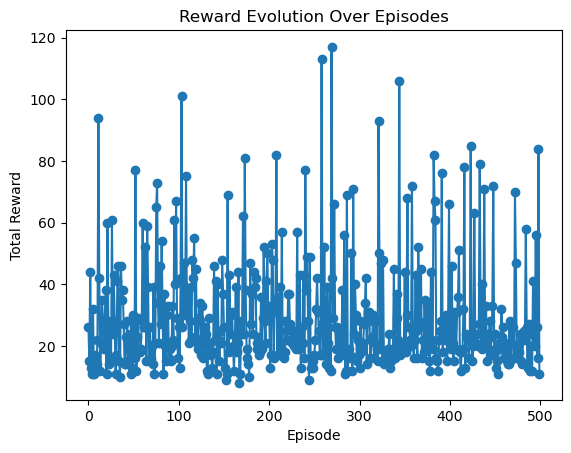

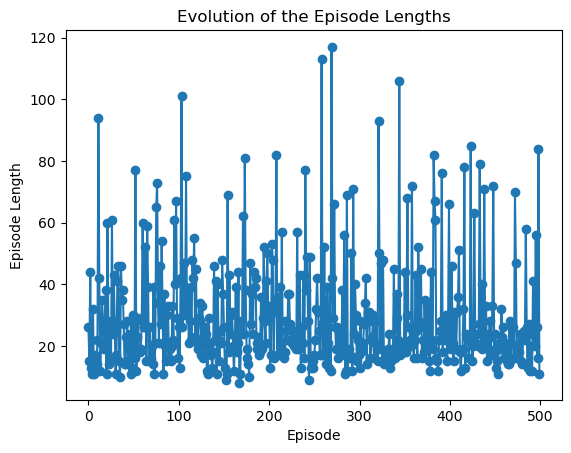

In [2]:
if __name__ == '__main__':

    # Forward Forward algo 
    env = gym.make("CartPole-v1")
    input_size = env.observation_space.shape[0] + 1
    print(f'input size : {input_size}')
    # Create the forward forward network
    ff_net =  Net([input_size, 20, 10])
    ff_net_trained = DRL_train_network(env, ff_net, num_episodes=500)

In [3]:
import gym
from gym import wrappers

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt


# plotting a graph of multiples tuples as points
def plot_tuples(tuples_list, x_label, y_label, title):
    # Extract x and y values from the list of tuples
    x_values, y_values = zip(*tuples_list)
    # Create a line plot
    plt.plot(x_values, y_values, marker='o', linestyle='-')
    # Add labels and a title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # Show the plot
    plt.show()


def DRL_train_network(env, ff_net, num_episodes=500):
    # Hyperparameters
    learning_rate = 0.001
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    memory_capacity = 1000
    batch_size = 32


    # Initialize replay memory for good moves
    episode_memory = []
    # Initialize replay memory for good moves
    replay_memory_positive_list = []
    # Initialize replay memory for bad moves
    replay_memory_negative_list = []
    
    # Initialize epsilon for epsilon-greedy exploration
    epsilon = epsilon_start
    # Reward evolution 
    reward_evolution = [] 
    # Episode length evolution
    ep_length_evolution = []


    #% Training loop
    for episode in range(num_episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        total_reward = 0
        episode_length = 0

        # This loop plays an episode until the agent dies
        while not done and episode_length < 2000:
            episode_length += 1
            # Epsilon-greedy exploration
            if random.random() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                with torch.no_grad():
                    # create intput state-action with default action being 0
                    input_1  = torch.cat((state, torch.tensor([1])), dim=0)
                    action_1 = ff_net.predict(input_1).item()
                    input_0  = torch.cat((state, torch.tensor([0])), dim=0)
                    action_0 = ff_net.predict(input_0).item()
                    action = 1 if action_1 > action_0 else 0
            # Take the selected action (New API)
            next_state, reward, terminated, truncated, info = env.step(action)
            # New API, the done flag can be detected wether the episode failed or succed
            done = terminated or truncated
            # put in a torch tensor
            next_state = torch.tensor(next_state, dtype=torch.float32)
            # Store the transition in replay memory
            # replay_memory.append((state, action, reward, next_state, done))
            # Just store the state action pair
            # TODO : idea, put the next state into the input of the netwrok to have a kind of anticipation??
            # Normally can't be done due to the enviornment
            episode_memory.append(torch.cat((state, torch.tensor([action])), dim=0))
            total_reward += reward
            state = next_state


        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        # sort the replay memory such that the good runs stays in it (for better estimation of pos and neg data)
        replay_memory_positive_list.append(episode_memory[:-20])
        replay_memory_positive_list = sorted(replay_memory_positive_list, key=len, reverse=True)
        replay_memory_positive = [item for sublist in replay_memory_positive_list for item in sublist]
        if len(replay_memory_positive_list) > 50:
            replay_memory_positive_list.pop()
    
        replay_memory_negative_list.append(episode_memory[-20:])
        replay_memory_negative_list = sorted(replay_memory_negative_list, key=len, reverse=True)
        replay_memory_negative = [item for sublist in replay_memory_negative_list for item in sublist]
        if len(replay_memory_negative_list) > 50:
            replay_memory_negative_list.pop()
            
        # Clear the replay memory of 1 run
        if len(replay_memory_positive) > memory_capacity:
            # Simple memory inside an array
            for _ in range(len(replay_memory_positive)-memory_capacity):
                # pop the last item of the list which should be the smallest run
                replay_memory_positive.pop()
            
        if len(replay_memory_negative) > memory_capacity:
            # Simple memory inside an array
            for _ in range(len(replay_memory_negative)-memory_capacity):
                # pop the last item of the list which should be the smallest run
                replay_memory_negative.pop()
                
        episode_memory.clear() # clear the memory of the past episode
        

        # Selecting k random sample in pos/neg memory data
        # x_pos has to be in a tensor
        neg_selection = random.choices(replay_memory_negative, k=128)
        # x_pos and x_neg must be tensor
        x_neg = torch.stack(neg_selection)
        if replay_memory_positive: # early stage when no pos data
            pos_selection = random.choices(replay_memory_positive, k=128)
            # x_pos and x_neg must be tensor
            x_pos = torch.stack(pos_selection)
        else:
            # Handle the case when replay_memory_positive is empty
            pos_selection = []        
        
        
        # Train the net if their is enough data
        if pos_selection and neg_selection:
            ff_net.train(x_pos,x_neg, num_epochs=200)
       
        
        # Log graph and plot outputs
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")
        print(f'length of repNeglist: {len(replay_memory_negative_list)} length of repNeg: {len(replay_memory_negative)} length of reppos: {len(replay_memory_positive)}')
        print(f'length of the first repposlist list {len(replay_memory_positive_list[0])}')
        
        # Reward evolution
        reward_evolution.append((episode, total_reward))
        # Episode length evolution
        ep_length_evolution.append((episode, episode_length))


    # plot the reward evolution
    plot_tuples(reward_evolution, 'Episode', 'Total Reward', 'Reward Evolution Over Episodes')
    # plot the reward evolution
    plot_tuples(ep_length_evolution, 'Episode', 'Episode Length', 'Evolution of the Episode Lengths')

    # Close the environment
    env.close()
    
    return ff_net




class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        # TODO : add L2 regularization
        #self.opt = torch.optim.Adam(self.parameters(), lr=0.03, weight_decay=5e-5)
        self.threshold = 2.0
    
    def forward(self, x):
        """Forward function that takes a set of points (matrix) as input
        """
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))
    
    def forward_onesample(self, x):
        """Same as the forward fucntion but takes a vector for x and not a matrix
        """
        x_norm = x.norm(2)
        x_direction = x / (x_norm + 1e-4)
        linear_result = torch.matmul(self.weight, x_direction) + self.bias
        output = torch.relu(linear_result)
        return output
        
    def goodness_onesample(self, x):
        """ Compute the goodness for one sample
        """
        with torch.no_grad():
            goodness = self.forward_onesample(x).pow(2).mean() - self.threshold
            forwarded_x = self.forward_onesample(x)
        return goodness, forwarded_x
    
    def goodness(self, X):
        """ Compute the goodness for multiples samples sotre in a tensor matrix
        """
        with torch.no_grad():
            goodness = self.forward(X).pow(2).mean(1) - self.threshold
            forwarded_x = self.forward(X)
        return goodness, forwarded_x
    
    def train(self, x_pos, x_neg, num_epochs=500):
        for i in range(num_epochs):
            g_pos = self.forward(x_pos).pow(2).mean(1) # g_pos: vector (size forward(s-a)) 
            g_neg = self.forward(x_neg).pow(2).mean(1)
            #TODO: explain and comprenand the loss function, Try some other types of loss function
            #TODO: maybe the loss function is nan because of that 
            positive_loss = torch.log(1 + torch.exp(-g_pos + self.threshold)).mean()
            negative_loss = torch.log(1 + torch.exp(g_neg - self.threshold)).mean()
            #loss = torch.log(1 + torch.exp(torch.cat([
            #    -g_pos + self.threshold,
            #    g_neg - self.threshold]))).mean()
            loss = positive_loss + negative_loss
            # loss = g_neg.mean() - g_pos.mean()
            self.opt.zero_grad()
            # compute the gradient make a step for only one layer
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


# Creation of the network with multiples layers
class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]
            
    def train(self, x_pos, x_neg, num_epochs):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg, num_epochs=num_epochs)

    def predict(self, x, Display=True):
        """Return the goodness of a given input
        Args:
            x (_type_): Input data, can be either a vector (single sample) or a matrix (multiple samples)
            Display (bool, optional): To print stuff. Defaults to True.
        Returns:
            torch tensor float : return the total goodness
        """
        g_tot = 0
        if len(x.shape) == 1: # Case of a vector
            for i, layer in enumerate(self.layers):
                g_layer, next_x = layer.goodness_onesample(x)
                x = next_x
                g_tot += g_layer
            if Display : print('goodness total for sample : ', g_tot)
                    
        elif len(x.shape)==2:
            for i, layer in enumerate(self.layers):
                g_layer, next_x = layer.goodness(x)
                x = next_x
                g_tot += g_layer
                
        return g_tot

input size : 5
Episode 1, Total Reward: 15.0
length of repNeglist: 1 length of repNeg: 15 length of reppos: 0
length of the first repposlist list 0
Episode 2, Total Reward: 14.0
length of repNeglist: 2 length of repNeg: 29 length of reppos: 0
length of the first repposlist list 0
Episode 3, Total Reward: 10.0
length of repNeglist: 3 length of repNeg: 39 length of reppos: 0
length of the first repposlist list 0
training layer 0 ...
training layer 1 ...
training layer 2 ...
Episode 4, Total Reward: 24.0
length of repNeglist: 4 length of repNeg: 59 length of reppos: 4
length of the first repposlist list 4
goodness total for sample :  tensor(-1.4045)
goodness total for sample :  tensor(-0.1030)
training layer 0 ...
training layer 1 ...
training layer 2 ...
Episode 5, Total Reward: 10.0
length of repNeglist: 5 length of repNeg: 69 length of reppos: 4
length of the first repposlist list 4
goodness total for sample :  tensor(-2.4505)
goodness total for sample :  tensor(-0.9975)
training layer

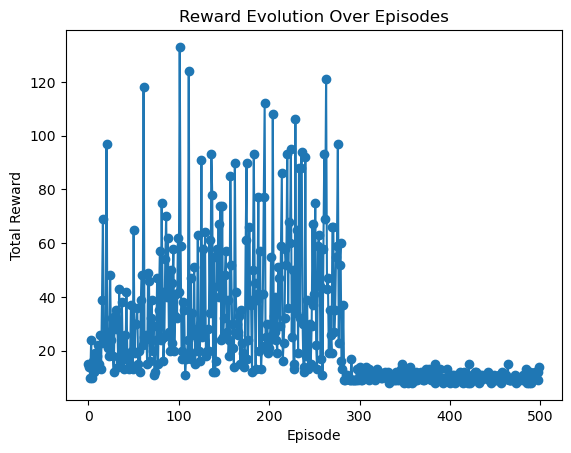

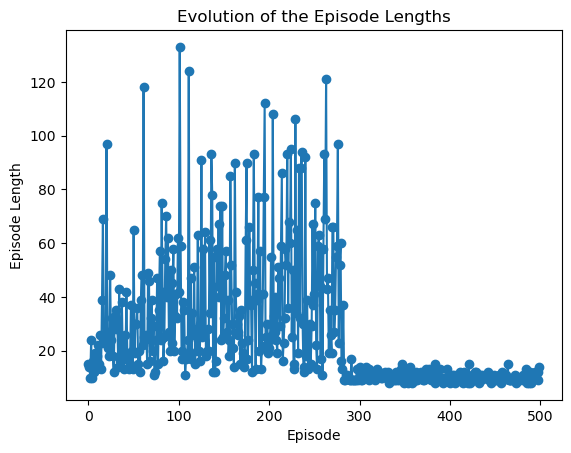

In [4]:
if __name__ == '__main__':

    # Forward Forward algo 
    env = gym.make("CartPole-v1")
    input_size = env.observation_space.shape[0] + 1
    print(f'input size : {input_size}')
    # Create the forward forward network
    ff_net =  Net([input_size, 20, 10, 10])
    ff_net_trained = DRL_train_network(env, ff_net, num_episodes=500)

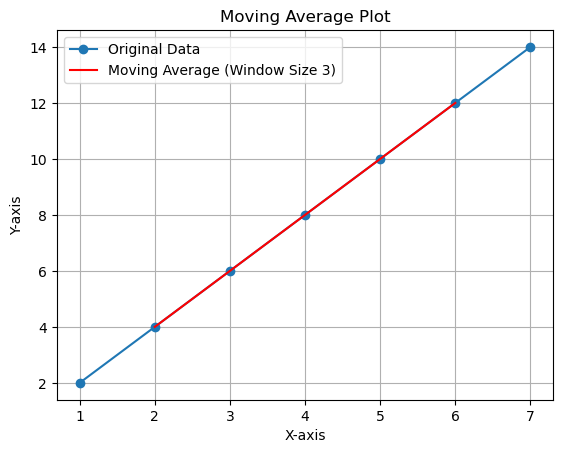

In [5]:
    data = [(1, 2), (2, 4), (3, 6), (4, 8), (5, 10), (6, 12), (7, 14)]

    # Extract x and y values into separate lists
    x_values, y_values = zip(*data)

    # Define the window size for the moving average
    window_size = 3  # You can adjust this value

    # Calculate the moving average using numpy
    moving_avg = np.convolve(y_values, np.ones(window_size)/window_size, mode='valid')

    # Create a new list of x values for the moving average
    x_avg = x_values[(window_size-1)//2 : -(window_size-1)//2]

    # Plot the original data points
    plt.plot(x_values, y_values, label='Original Data', marker='o')

    # Plot the moving average
    plt.plot(x_avg, moving_avg, label=f'Moving Average (Window Size {window_size})', color='red')

    # Add labels and legend
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.title('Moving Average Plot')
    plt.show()

In [6]:
ep_length_evolution

NameError: name 'ep_length_evolution' is not defined

In [7]:
import gym
from gym import wrappers

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt


# plotting a graph of multiples tuples as points
def plot_tuples(tuples_list, x_label, y_label, title):
    # Extract x and y values from the list of tuples
    x_values, y_values = zip(*tuples_list)
    # Create a line plot
    plt.plot(x_values, y_values, marker='o', linestyle='-')
    # Add labels and a title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    # Show the plot
    plt.show()


def DRL_train_network(env, ff_net, num_episodes=500):
    # Hyperparameters
    learning_rate = 0.001
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_end = 0.01
    epsilon_decay = 0.995
    memory_capacity = 1000
    batch_size = 32


    # Initialize replay memory for good moves
    episode_memory = []
    # Initialize replay memory for good moves
    replay_memory_positive_list = []
    # Initialize replay memory for bad moves
    replay_memory_negative_list = []
    
    # Initialize epsilon for epsilon-greedy exploration
    epsilon = epsilon_start
    # Reward evolution 
    reward_evolution = [] 
    # Episode length evolution
    ep_length_evolution = []


    #% Training loop
    for episode in range(num_episodes):
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        total_reward = 0
        episode_length = 0

        # This loop plays an episode until the agent dies
        while not done and episode_length < 2000:
            episode_length += 1
            # Epsilon-greedy exploration
            if random.random() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                with torch.no_grad():
                    # create intput state-action with default action being 0
                    input_1  = torch.cat((state, torch.tensor([1])), dim=0)
                    action_1 = ff_net.predict(input_1).item()
                    input_0  = torch.cat((state, torch.tensor([0])), dim=0)
                    action_0 = ff_net.predict(input_0).item()
                    action = 1 if action_1 > action_0 else 0
            # Take the selected action (New API)
            next_state, reward, terminated, truncated, info = env.step(action)
            # New API, the done flag can be detected wether the episode failed or succed
            done = terminated or truncated
            # put in a torch tensor
            next_state = torch.tensor(next_state, dtype=torch.float32)
            # Store the transition in replay memory
            # replay_memory.append((state, action, reward, next_state, done))
            # Just store the state action pair
            # TODO : idea, put the next state into the input of the netwrok to have a kind of anticipation??
            # Normally can't be done due to the enviornment
            episode_memory.append(torch.cat((state, torch.tensor([action])), dim=0))
            total_reward += reward
            state = next_state


        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        
        # sort the replay memory such that the good runs stays in it (for better estimation of pos and neg data)
        replay_memory_positive_list.append(episode_memory[:-20])
        replay_memory_positive_list = sorted(replay_memory_positive_list, key=len, reverse=True)
        replay_memory_positive = [item for sublist in replay_memory_positive_list for item in sublist]
        if len(replay_memory_positive_list) > 50:
            replay_memory_positive_list.pop()
    
        replay_memory_negative_list.append(episode_memory[-20:])
        replay_memory_negative_list = sorted(replay_memory_negative_list, key=len, reverse=True)
        replay_memory_negative = [item for sublist in replay_memory_negative_list for item in sublist]
        if len(replay_memory_negative_list) > 50:
            replay_memory_negative_list.pop()
            
        # Clear the replay memory of 1 run
        if len(replay_memory_positive) > memory_capacity:
            # Simple memory inside an array
            for _ in range(len(replay_memory_positive)-memory_capacity):
                # pop the last item of the list which should be the smallest run
                replay_memory_positive.pop()
            
        if len(replay_memory_negative) > memory_capacity:
            # Simple memory inside an array
            for _ in range(len(replay_memory_negative)-memory_capacity):
                # pop the last item of the list which should be the smallest run
                replay_memory_negative.pop()
                
        episode_memory.clear() # clear the memory of the past episode
        

        # Selecting k random sample in pos/neg memory data
        # x_pos has to be in a tensor
        neg_selection = random.choices(replay_memory_negative, k=128)
        # x_pos and x_neg must be tensor
        x_neg = torch.stack(neg_selection)
        if replay_memory_positive: # early stage when no pos data
            pos_selection = random.choices(replay_memory_positive, k=128)
            # x_pos and x_neg must be tensor
            x_pos = torch.stack(pos_selection)
        else:
            # Handle the case when replay_memory_positive is empty
            pos_selection = []        
        
        
        # Train the net if their is enough data
        if pos_selection and neg_selection:
            print('--------------start the training-----------------')
            print('replay pos mem list :',[len(inner_list) for inner_list in replay_memory_positive_list])
            print('replay neg mem list :',[len(inner_list) for inner_list in replay_memory_negative_list])
            
            ff_net.train(x_pos,x_neg, num_epochs=len(replay_memory_positive_list[0]))
       
        
        # Log graph and plot outputs
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")
        print(f'length of repNeglist: {len(replay_memory_negative_list)} length of repNeg: {len(replay_memory_negative)} length of reppos: {len(replay_memory_positive)}')
        print(f'length of the first repposlist list {len(replay_memory_positive_list[0])}')
        
        # Reward evolution
        reward_evolution.append((episode, total_reward))
        # Episode length evolution
        ep_length_evolution.append((episode, episode_length))


 
    logs = (reward_evolution, ep_length_evolution)
    
    # Close the environment
    env.close()
    
    return ff_net, logs




class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        # TODO : add L2 regularization
        #self.opt = torch.optim.Adam(self.parameters(), lr=0.03, weight_decay=5e-5)
        self.threshold = 2.0
    
    def forward(self, x):
        """Forward function that takes a set of points (matrix) as input
        """
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))
    
    def forward_onesample(self, x):
        """Same as the forward fucntion but takes a vector for x and not a matrix
        """
        x_norm = x.norm(2)
        x_direction = x / (x_norm + 1e-4)
        linear_result = torch.matmul(self.weight, x_direction) + self.bias
        output = torch.relu(linear_result)
        return output
        
    def goodness_onesample(self, x):
        """ Compute the goodness for one sample
        """
        with torch.no_grad():
            goodness = self.forward_onesample(x).pow(2).mean() - self.threshold
            forwarded_x = self.forward_onesample(x)
        return goodness, forwarded_x
    
    def goodness(self, X):
        """ Compute the goodness for multiples samples sotre in a tensor matrix
        """
        with torch.no_grad():
            goodness = self.forward(X).pow(2).mean(1) - self.threshold
            forwarded_x = self.forward(X)
        return goodness, forwarded_x
    
    def train(self, x_pos, x_neg, num_epochs=500):
        for i in range(num_epochs):
            g_pos = self.forward(x_pos).pow(2).mean(1) # g_pos: vector (size forward(s-a)) 
            g_neg = self.forward(x_neg).pow(2).mean(1)
            #TODO: explain and comprenand the loss function, Try some other types of loss function
            #TODO: maybe the loss function is nan because of that 
            positive_loss = torch.log(1 + torch.exp(-g_pos + self.threshold)).mean()
            negative_loss = torch.log(1 + torch.exp(g_neg - self.threshold)).mean()
            #loss = torch.log(1 + torch.exp(torch.cat([
            #    -g_pos + self.threshold,
            #    g_neg - self.threshold]))).mean()
            loss = positive_loss + negative_loss
            # loss = g_neg.mean() - g_pos.mean()
            self.opt.zero_grad()
            # compute the gradient make a step for only one layer
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()


# Creation of the network with multiples layers
class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1])]
            
    def train(self, x_pos, x_neg, num_epochs):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg, num_epochs=num_epochs)

    def predict(self, x, Display=True):
        """Return the goodness of a given input
        Args:
            x (_type_): Input data, can be either a vector (single sample) or a matrix (multiple samples)
            Display (bool, optional): To print stuff. Defaults to True.
        Returns:
            torch tensor float : return the total goodness
        """
        g_tot = 0
        if len(x.shape) == 1: # Case of a vector
            for i, layer in enumerate(self.layers):
                g_layer, next_x = layer.goodness_onesample(x)
                x = next_x
                g_tot += g_layer
            if Display : print('goodness total for sample : ', g_tot)
                    
        elif len(x.shape)==2:
            for i, layer in enumerate(self.layers):
                g_layer, next_x = layer.goodness(x)
                x = next_x
                g_tot += g_layer
                
        return g_tot

input size : 5
Episode 1, Total Reward: 10.0
length of repNeglist: 1 length of repNeg: 10 length of reppos: 0
length of the first repposlist list 0
Episode 2, Total Reward: 18.0
length of repNeglist: 2 length of repNeg: 28 length of reppos: 0
length of the first repposlist list 0
Episode 3, Total Reward: 19.0
length of repNeglist: 3 length of repNeg: 47 length of reppos: 0
length of the first repposlist list 0
--------------start the training-----------------
replay pos mem list : [2, 0, 0, 0]
replay neg mem list : [20, 19, 18, 10]
training layer 0 ...
training layer 1 ...
training layer 2 ...
Episode 4, Total Reward: 22.0
length of repNeglist: 4 length of repNeg: 67 length of reppos: 2
length of the first repposlist list 2
--------------start the training-----------------
replay pos mem list : [2, 0, 0, 0, 0]
replay neg mem list : [20, 19, 19, 18, 10]
training layer 0 ...
training layer 1 ...
training layer 2 ...
Episode 5, Total Reward: 19.0
length of repNeglist: 5 length of repNeg: 

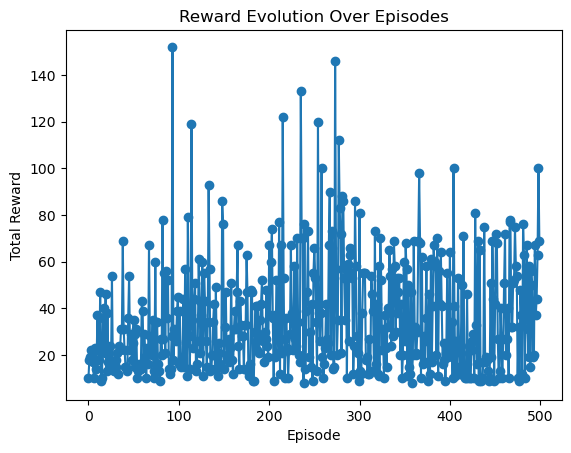

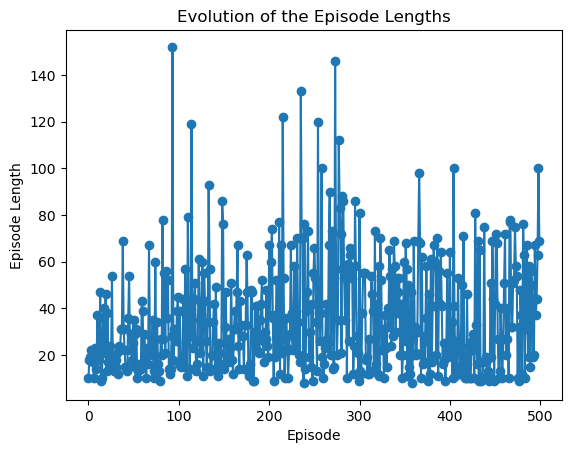

In [8]:
if __name__ == '__main__':

    # Forward Forward algo 
    env = gym.make("CartPole-v1")
    input_size = env.observation_space.shape[0] + 1
    print(f'input size : {input_size}')
    # Create the forward forward network
    ff_net =  Net([input_size, 20, 10, 10])
    ff_net_trained, logs = DRL_train_network(env, ff_net, num_episodes=500)
    
    # plot the logs
    reward_evolution, ep_length_evolution = logs
    # plot the reward evolution
    plot_tuples(reward_evolution, 'Episode', 'Total Reward', 'Reward Evolution Over Episodes')
    # plot the reward evolution
    plot_tuples(ep_length_evolution, 'Episode', 'Episode Length', 'Evolution of the Episode Lengths')

In [9]:
reward_evolution

[(0, 10.0),
 (1, 18.0),
 (2, 19.0),
 (3, 22.0),
 (4, 19.0),
 (5, 17.0),
 (6, 10.0),
 (7, 23.0),
 (8, 14.0),
 (9, 18.0),
 (10, 37.0),
 (11, 22.0),
 (12, 18.0),
 (13, 47.0),
 (14, 9.0),
 (15, 10.0),
 (16, 36.0),
 (17, 40.0),
 (18, 21.0),
 (19, 46.0),
 (20, 13.0),
 (21, 38.0),
 (22, 17.0),
 (23, 14.0),
 (24, 24.0),
 (25, 16.0),
 (26, 54.0),
 (27, 15.0),
 (28, 13.0),
 (29, 15.0),
 (30, 15.0),
 (31, 18.0),
 (32, 21.0),
 (33, 12.0),
 (34, 24.0),
 (35, 22.0),
 (36, 31.0),
 (37, 31.0),
 (38, 69.0),
 (39, 31.0),
 (40, 22.0),
 (41, 15.0),
 (42, 15.0),
 (43, 13.0),
 (44, 36.0),
 (45, 54.0),
 (46, 22.0),
 (47, 29.0),
 (48, 18.0),
 (49, 25.0),
 (50, 35.0),
 (51, 15.0),
 (52, 29.0),
 (53, 31.0),
 (54, 10.0),
 (55, 13.0),
 (56, 16.0),
 (57, 14.0),
 (58, 14.0),
 (59, 43.0),
 (60, 39.0),
 (61, 16.0),
 (62, 29.0),
 (63, 19.0),
 (64, 10.0),
 (65, 23.0),
 (66, 16.0),
 (67, 67.0),
 (68, 28.0),
 (69, 22.0),
 (70, 20.0),
 (71, 35.0),
 (72, 10.0),
 (73, 13.0),
 (74, 60.0),
 (75, 16.0),
 (76, 34.0),
 (77, 16.0

In [10]:
def moving_average(tuples_list, x_axis_name='Time', y_axsis_name='Reward', title='Moving average plot', window_size=3):
    # Check of good inputs
    if not isinstance(x_axis_name, str) or not isinstance(y_axsis_name, str) or not isinstance(title, str) :
        raise ValueError("Input x_name, y_name, title must be a string")
    if not isinstance(tuples_list, list):
        raise ValueError("Input must be a list")
    for item in tuples_list:
        if not isinstance(item, tuple) or len(item) != 2:
            raise ValueError("Each element in the list must be a 2D tuple (tuple with two elements)")
    
    # Extract x and y values into separate lists
    x_values, y_values = zip(*tuples_list)

    # Calculate the moving average using numpy
    moving_avg = np.convolve(y_values, np.ones(window_size)/window_size, mode='valid')

    # Create a new list of x values for the moving average
    x_avg = x_values[(window_size-1)//2 : -(window_size-1)//2]

    # Plot the original data points
    plt.scatter(x_values, y_values, label='Original Data', marker='o')

    # Plot the moving average
    plt.plot(x_avg, moving_avg, label=f'Moving Average (Window Size {window_size})', color='red')

    # Add labels and legend
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axsis_name)
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.title(title)
    plt.show()

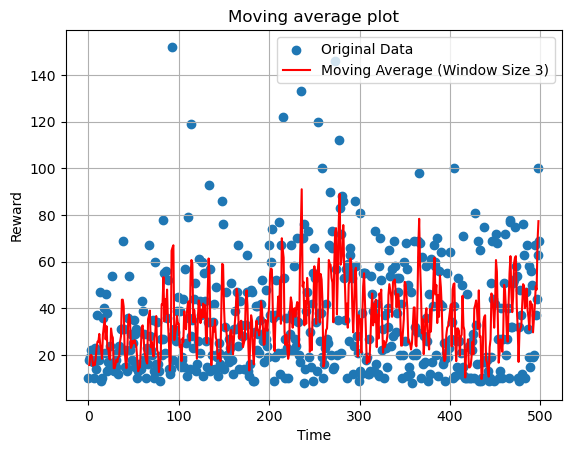

In [11]:
moving_average(reward_evolution, x_axis_name='Time', y_axsis_name='Reward', title='Moving average plot', window_size=3)